## Лабораторна робота 2 з ІСППР (варіант 22)
### Виконали студенти групи КІ-31мп Шабо О.А. та Сотник Д.C.
##### Датасет: https://www.kaggle.com/datasets/rahulsah06/gooogle-stock-pricedf_test.head()

# Imports

In [104]:
import torch
import random
import gc
import os
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import itertools as it

from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm
from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.optim import Adam
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Reproducibility and constants

In [2]:
if torch.cuda.is_available():
    print("PyTorch GPU is available")
else:
    print("PyTorch GPU is not available")
DEVICE = "cuda"

PyTorch GPU is available


In [3]:
RANDOM_SEED = 10

# Seed the RNG for all devices (both CPU and CUDA)
torch.manual_seed(RANDOM_SEED)
# Set python seed
random.seed(RANDOM_SEED)
# Set numpy seed
np.random.seed(RANDOM_SEED)

torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

# Worker initialization function for data loaders (simplest approach)
def seed_worker(worker_id):
    worker_seed = (torch.initial_seed() + worker_id) % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g_train = torch.Generator().manual_seed(RANDOM_SEED)

# Підготовка даних

In [4]:
df_train = pd.read_csv('/kaggle/input/gooogle-stock-price/Google_Stock_Price_Train.csv')
df_train.tail()

,Date,Open,High,Low,Close,Volume
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"
1257,12/30/2016,782.75,782.78,770.41,771.82,"1,770,000"


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [6]:
df_test = pd.read_csv('/kaggle/input/gooogle-stock-price/Google_Stock_Price_Test.csv')
df_test.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    20 non-null     object 
 1   Open    20 non-null     float64
 2   High    20 non-null     float64
 3   Low     20 non-null     float64
 4   Close   20 non-null     float64
 5   Volume  20 non-null     object 
dtypes: float64(4), object(2)
memory usage: 1.1+ KB


In [8]:
df_train['Close'] = pd.to_numeric(df_train['Close'].str.replace(',', ''), errors='coerce')
df = pd.concat([df_train, df_test], axis=0)

In [9]:
# Select features and target for modeling
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df['Volume'] = pd.to_numeric(df['Volume'].str.replace(',', ''), errors='coerce')

features = df[['Open', 'High', 'Low', 'Volume']]
target = df['Close'].to_frame()

# Normalize features
feature_scaler = StandardScaler()
target_scaler = deepcopy(feature_scaler)
split_index = int(len(df) * 0.75)
feature_scaler.fit(features.head(split_index)) # we have access only to train set
target_scaler.fit(target.head(split_index)) # we have access only to train set
features_normalized = feature_scaler.transform(features)
target_normalized = target_scaler.transform(target)

# Split the data
X_train = features_normalized[:split_index]
y_train = target_normalized[:split_index]
X_test = features_normalized[split_index:]
y_test = target_normalized[split_index:]

In [10]:
INPUT_SEQUENCE = 14  # For example, use 5 days of data to predict
OUTPUT_SEQUENCE = 10  # Predict the next 10 days 

# Function to create dataset with sequences
def create_sequences(features, target, input_sequence, output_sequence):
    X = []
    y = []

    for i in range(len(features) - input_sequence - output_sequence + 1):
        X.append(features[i:(i + input_sequence)])
        y.append(target[(i + input_sequence):(i + input_sequence + output_sequence)])
    
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(X_train, y_train, INPUT_SEQUENCE, OUTPUT_SEQUENCE)
X_test, y_test = create_sequences(X_test, y_test, INPUT_SEQUENCE, OUTPUT_SEQUENCE)


# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [11]:
features_normalized.shape[0]

1278

In [12]:
X_train_tensor.shape

torch.Size([935, 14, 4])

In [13]:
X_test_tensor.shape

torch.Size([297, 14, 4])

In [14]:
y_train_tensor.shape

torch.Size([935, 10, 1])

In [15]:
y_test_tensor.shape

torch.Size([297, 10, 1])

In [16]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

# Батьківський клас RNN для наступних моделей

In [17]:
class BasicRNN():
    def fit(self, X_train, y_train, X_test, y_test, learning_rate=0.01,
            num_epochs=100, batch_size=32, verbose=True, optimizer_class=Adam,
            loss_fn=nn.MSELoss):
        optimizer = optimizer_class(self.parameters(), lr=learning_rate)
        criterion = loss_fn()

        train_dataset = TensorDataset(X_train, y_train)
        test_dataset = TensorDataset(X_test, y_test)

        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

        train_losses = []
        test_losses = []

        for epoch in tqdm(range(num_epochs), disable=not verbose):
            self.train()
            train_loss = 0.0
            best_test_loss = np.inf
            best_model = None
            for X_batch, y_batch in train_loader:
                X_batch = X_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
                optimizer.zero_grad()
                outputs = self(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()  # Correct loss calculation
            train_loss /= len(train_loader.dataset)
            train_losses.append(train_loss)
            test_loss = self.evaluate(test_loader, criterion)
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                best_model = deepcopy(self)
            test_losses.append(test_loss)

            if verbose and (epoch+1) % 10 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

        self.train_losses = train_losses
        self.test_losses = test_losses
        best_model.train_losses = np.copy(train_losses)
        best_model.test_losses = np.copy(test_losses)
        gc.collect()
        return best_model, best_test_loss

    def plot_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss over Epochs')
        plt.legend()
        plt.show()

    def evaluate(self, data_loader, criterion):
        self.eval()
        total_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in data_loader:
                X_batch = X_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
                outputs = self(X_batch)
                loss = criterion(outputs, y_batch)
                total_loss += loss.item()  # Correct loss calculation
        return total_loss / len(data_loader.dataset)
    

# Модель із використанням базових рекурентних нейронів

In [18]:
class RNNModel(nn.Module, BasicRNN):
    def __init__(self, input_dim, hidden_dim, output_dim, input_sequence, output_sequence):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        # Adjust output dimension to account for output_sequence
        self.fc = nn.Linear(hidden_dim, output_dim * output_sequence)
        self.input_sequence = input_sequence
        self.output_sequence = output_sequence

    def forward(self, x):
        # Assume x is already shaped as (batch, input_sequence, features)
        self.rnn.flatten_parameters()  # Optimize for GPU
        out, _ = self.rnn(x)
        # Reshape the output to fit into the fully connected layer
        out = out[:, -1, :]  # Taking the output of the last time step
        out = self.fc(out)
        # Reshape the output to have the output_sequence in the last dimension
        out = out.view(-1, self.output_sequence, out.size(-1) // self.output_sequence)
        return out

    @staticmethod
    def find_best_parameters(X_train, y_train, X_test, y_test, parameter_grid, criterion=nn.MSELoss()):
        best_loss = float('inf')
        best_params = None
        best_model = None

        for params in tqdm(list(it.product(*parameter_grid.values()))):
            lr, hidden_dim, batch_size = params
            input_dim = X_train.shape[-1]
            output_dim = y_train.shape[-1]

            model = RNNModel(
                input_dim=X_train.shape[-1], hidden_dim=hidden_dim, output_dim=y_train.shape[-1], 
                input_sequence=INPUT_SEQUENCE, output_sequence=OUTPUT_SEQUENCE
            ).to(DEVICE)
            current_best_model, current_best_test_loss = model.fit(X_train, y_train, X_test, y_test, num_epochs=300, batch_size=batch_size, learning_rate=lr, verbose=False)

            if current_best_test_loss < best_loss:
                best_loss = current_best_test_loss
                best_params = params
                best_model = deepcopy(current_best_model)

        print(f'Best parameters found: {best_params}, with validation loss: {best_loss}')
        return best_params, best_model

In [19]:
# parameter_grid = {
#     'lr': [0.01],
#     'hidden_dim': [25],
#     'batch_size': [64]
# }
parameter_grid = {
    'lr': [0.01, 0.005, 0.001],
    'hidden_dim': [15, 25, 40],
    'batch_size': [32, 64]
}

(best_rnn_params, best_rnn_model) = RNNModel.find_best_parameters(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, parameter_grid)

  0%|          | 0/18 [00:00<?, ?it/s]

Best parameters found: (0.001, 25, 64), with validation loss: 0.0005684672268452468


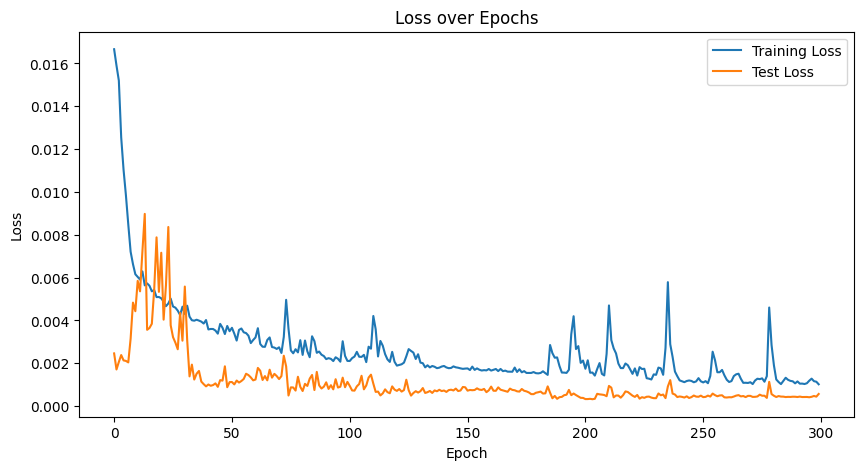

In [20]:
best_rnn_model.plot_loss()

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def metrics(model):
    y_pred_test = model(X_test_tensor.to(DEVICE)).detach().cpu().numpy()
    y_test_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))

    # Перетворення передбачень з нормалізованого вигляду назад до оригінальних значень
    y_pred_test_unscaled = target_scaler.inverse_transform(y_pred_test.reshape(-1, 1))

    # Обчислення RMSE
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_test_unscaled))

    # Обчислення MAE
    mae = mean_absolute_error(y_test_actual, y_pred_test_unscaled)

    # Обчислення MAPE
    mape = np.mean(np.abs((y_test_actual - y_pred_test_unscaled) / y_test_actual)) * 100

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}%")
    
    
metrics(best_rnn_model)

RMSE: 34.27329288759487
MAE: 28.250315504491528
MAPE: 3.777568814188153%


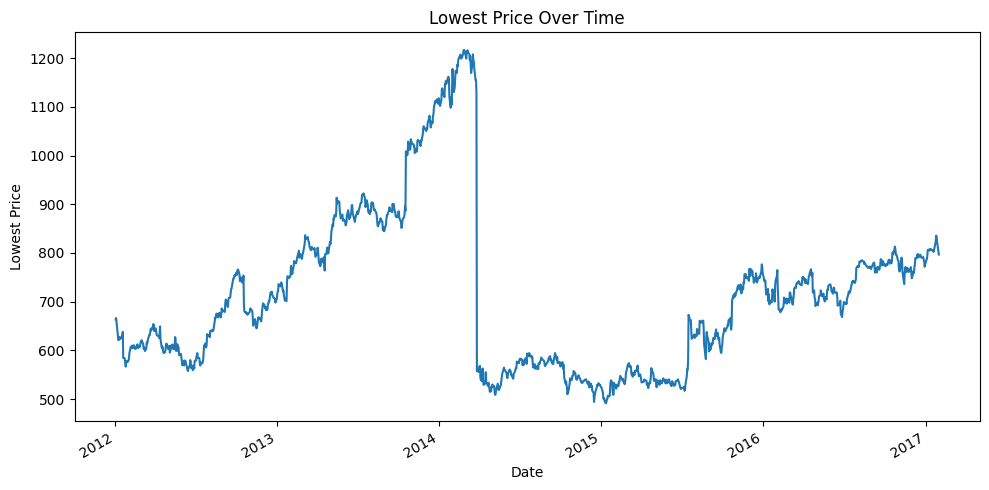

In [22]:
# Plot 'Avg' over time
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Close'], label='Lowest Price')
plt.xlabel("Date")
plt.ylabel("Lowest Price")
plt.title("Lowest Price Over Time")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

# Функція для виводу передбачень

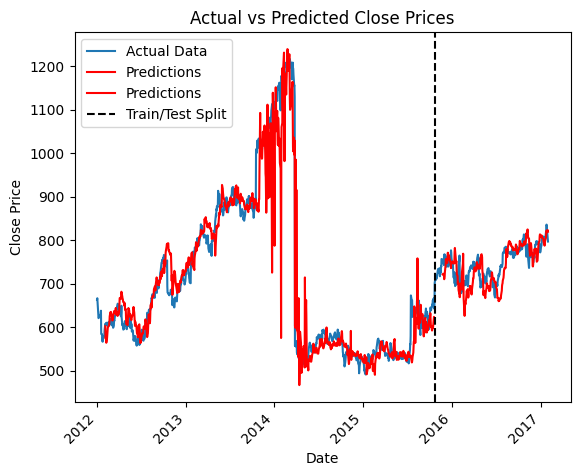

In [23]:
def plot_data_and_prediction(model, features_scaler, target_scaler, split_index, input_sequence, output_sequence, xticks_data=df['Date'].values, yticks_data=df['Close'].values, features_data=df.drop(['Date', 'Close'], axis=1),):
    _, ax = plt.subplots()
    # Plot real data
    ax.plot(xticks_data, yticks_data, label='Actual Data')
    
    # Prepare to plot predicted data
    # Note: Adjust your model prediction and data preparation as necessary

    # Assuming X_train_tensor and X_test_tensor are globally accessible; adjust as necessary
    for tensor, is_train in [(X_train_tensor, True), (X_test_tensor, False)]:
        predictions = []  # This will store all your predictions
        prediction_dates = []  # This will store corresponding dates for predictions
        # Generate predictions
        y_pred_tensor = model.forward(tensor.to(DEVICE)).detach()
        y_pred_unscaled = target_scaler.inverse_transform(y_pred_tensor.cpu().numpy().reshape(-1, 1)).flatten()

        # Since the predictions may not cover every date (especially with output sequences), you might need to adjust this part
        # Here we're plotting the last day of each predicted sequence for simplicity
        start_idx = split_index if not is_train else 0
        start_idx += input_sequence + output_sequence - 1
        ax.plot(xticks_data[start_idx:start_idx+tensor.shape[0]],\
                [y_pred_unscaled[(i + 1) * output_sequence - 1] for i in range(tensor.shape[0])],
                'r', label='Predictions')
        if is_train: assert start_idx+tensor.shape[0] == split_index # check correctness of plots
        else: assert start_idx+tensor.shape[0] == len(xticks_data)

    # Additional plot formatting
    plt.axvline(x=xticks_data[split_index], color='black', linestyle='--', label='Train/Test Split')
    ax.set_xlabel("Date")
    ax.set_ylabel("Close Price")
    ax.set_title('Actual vs Predicted Close Prices')
    plt.legend()
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    
    plt.show()

# Call your plot function with the appropriate parameters
plot_data_and_prediction(model=best_rnn_model, features_scaler=feature_scaler, target_scaler=target_scaler,
                         split_index=split_index,
                         input_sequence=INPUT_SEQUENCE, output_sequence=OUTPUT_SEQUENCE)

# Базова LSTM модель

In [24]:
class LSTMModel(nn.Module, BasicRNN):
    def __init__(self, input_dim, hidden_dim, output_dim, input_sequence, output_sequence):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim * output_sequence)
        self.input_sequence = input_sequence
        self.output_sequence = output_sequence

    def forward(self, x):
        x = x.view(-1, self.input_sequence, x.size(-1))  # Ensure input is (batch, sequence, features)
        self.lstm.flatten_parameters()
        out, (h_n, c_n) = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        out = out.view(-1, self.output_sequence, out.size(-1) // self.output_sequence)
        return out
    
    @staticmethod
    def find_best_parameters(X_train, y_train, X_test, y_test, parameter_grid, criterion=nn.MSELoss()):
        best_loss = float('inf')
        best_params = None
        best_model = None

        for params in tqdm(list(it.product(*parameter_grid.values()))):
            lr, hidden_dim, batch_size = params
            input_dim = X_train.shape[-1]
            output_dim = y_train.shape[-1]

            model = LSTMModel(
                input_dim=X_train.shape[-1], hidden_dim=hidden_dim, output_dim=y_train.shape[-1], 
                input_sequence=INPUT_SEQUENCE, output_sequence=OUTPUT_SEQUENCE
            ).to(DEVICE)
            current_best_model, current_best_test_loss = model.fit(X_train, y_train, X_test, y_test, num_epochs=300, batch_size=batch_size, learning_rate=lr, verbose=False)

            if current_best_test_loss < best_loss:
                best_loss = current_best_test_loss
                best_params = params
                best_model = deepcopy(current_best_model)
                
        print(f'Best parameters found: {best_params}, with validation loss: {best_loss}')
        return best_params, best_model

In [25]:
parameter_grid = {
    'lr': [0.1, 0.01, 0.001],
    'hidden_dim': [15, 25, 40],
    'batch_size': [32, 64]
}
# parameter_grid = {
#     'lr': [0.001],
#     'hidden_dim': [100],
#     'batch_size': [32]
# }

(best_lstm_params, best_lstm_model) = LSTMModel.find_best_parameters(
    X_train_tensor, y_train_tensor, 
    X_test_tensor, y_test_tensor, 
    parameter_grid)

  0%|          | 0/18 [00:00<?, ?it/s]

Best parameters found: (0.001, 15, 64), with validation loss: 0.0015355041156513522


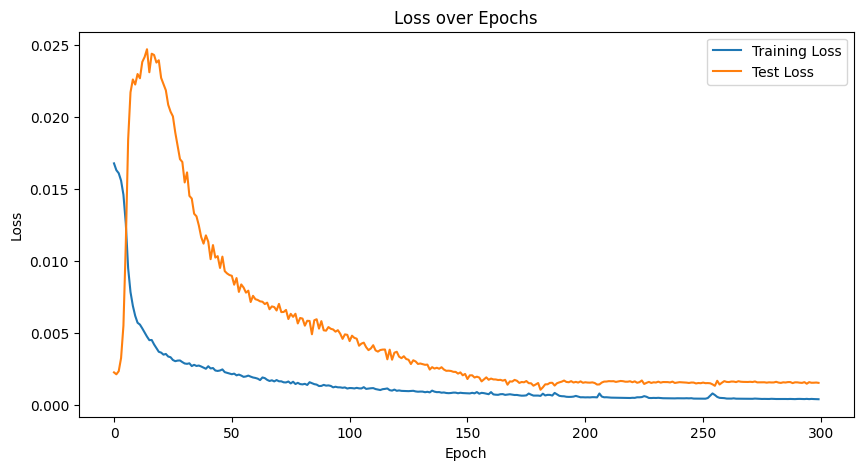

In [26]:
best_lstm_model.plot_loss()

In [27]:
metrics(best_lstm_model)

RMSE: 54.33006544553164
MAE: 47.903373862321125
MAPE: 6.271821440086328%


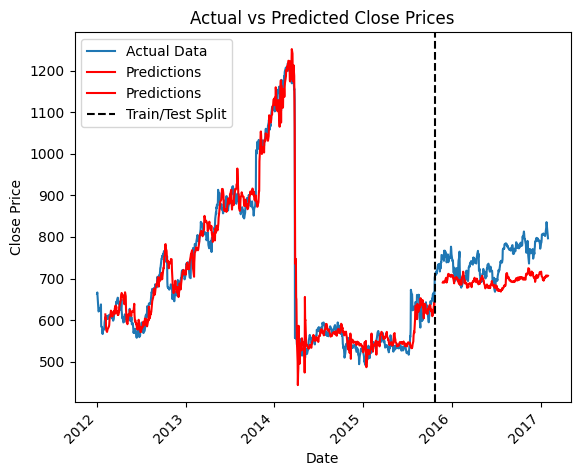

In [28]:
plot_data_and_prediction(model=best_lstm_model, features_scaler=feature_scaler, target_scaler=target_scaler,
                         split_index=split_index,
                         input_sequence=INPUT_SEQUENCE, output_sequence=OUTPUT_SEQUENCE)

# Базова GRU модель

In [29]:
class GRUModel(nn.Module, BasicRNN):
    def __init__(self, input_dim, hidden_dim, output_dim, input_sequence, output_sequence):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)  # Use GRU instead of RNN
        # Adjust output dimension to account for output_sequence
        self.fc = nn.Linear(hidden_dim, output_dim * output_sequence)
        self.input_sequence = input_sequence
        self.output_sequence = output_sequence

    def forward(self, x):
        # Assume x is already shaped as (batch, input_sequence, features)
        out, _ = self.gru(x)  # Process input through the GRU layer
        # Reshape the output to fit into the fully connected layer
        out = out[:, -1, :]  # Taking the output of the last time step
        out = self.fc(out)
        # Reshape the output to have the output_sequence in the last dimension
        out = out.view(-1, self.output_sequence, out.size(-1) // self.output_sequence)
        return out
    
    @staticmethod
    def find_best_parameters(X_train, y_train, X_test, y_test, parameter_grid, criterion=nn.MSELoss()):
        best_loss = float('inf')
        best_params = None
        best_model = None

        for params in tqdm(list(it.product(*parameter_grid.values()))):
            lr, hidden_dim, batch_size = params
            input_dim = X_train.shape[-1]
            output_dim = y_train.shape[-1]

            model = GRUModel(
                input_dim=X_train.shape[-1], hidden_dim=hidden_dim, output_dim=y_train.shape[-1], 
                input_sequence=INPUT_SEQUENCE, output_sequence=OUTPUT_SEQUENCE
            ).to(DEVICE)
            current_best_model, current_best_test_loss = model.fit(X_train, y_train, X_test, y_test, num_epochs=300, batch_size=batch_size, learning_rate=lr, verbose=False)


            if current_best_test_loss < best_loss:
                best_loss = current_best_test_loss
                best_params = params
                best_model = deepcopy(current_best_model)

        print(f'Best parameters found: {best_params}, with validation loss: {best_loss}')
        return best_params, best_model

In [30]:
parameter_grid = {
    'lr': [0.01, 0.005, 0.001],
    'hidden_dim': [12, 25, 35],
    'batch_size': [32, 64]
}
# parameter_grid = {
#     'lr': [0.01],
#     'hidden_dim': [25],
#     'batch_size': [64]
# }
(best_gru_params, best_gru_model) = GRUModel.find_best_parameters(
    X_train_tensor, y_train_tensor, 
    X_test_tensor, y_test_tensor, 
    parameter_grid)

  0%|          | 0/18 [00:00<?, ?it/s]

Best parameters found: (0.005, 25, 64), with validation loss: 0.0011982532274542432


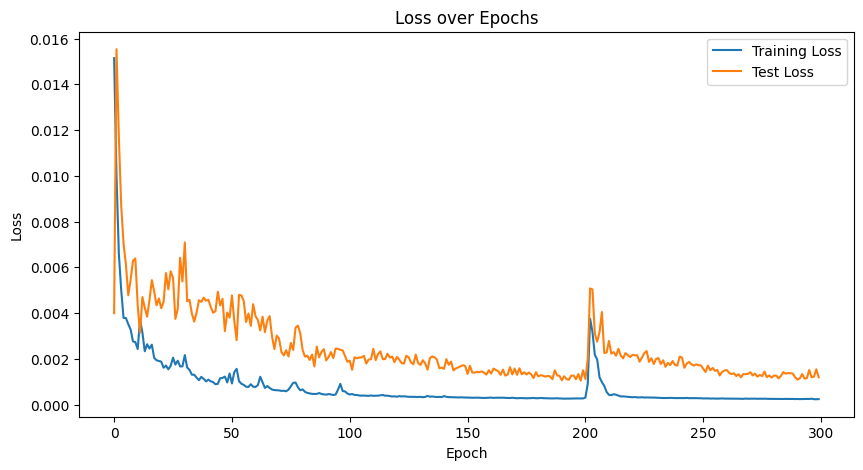

In [31]:
best_gru_model.plot_loss()

In [32]:
metrics(best_gru_model)

RMSE: 48.49436315353167
MAE: 39.62147917242082
MAPE: 5.218064106382472%


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:1102: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:1102: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:1102: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


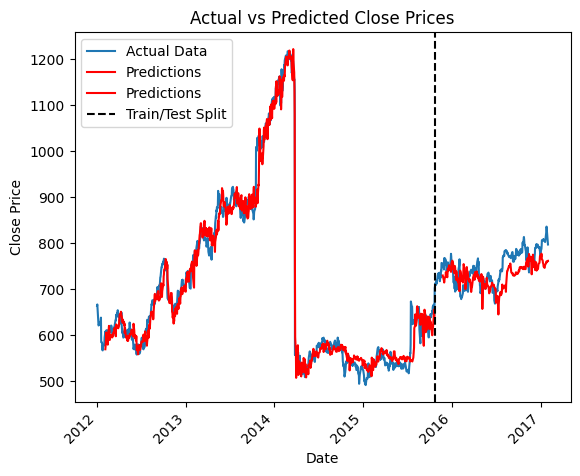

In [33]:
plot_data_and_prediction(model=best_gru_model, features_scaler=feature_scaler, target_scaler=target_scaler,
                         split_index=split_index,
                         input_sequence=INPUT_SEQUENCE, output_sequence=OUTPUT_SEQUENCE)

# LSTM з декількома шарами

In [34]:
class LSTMDeepModel(nn.Module, BasicRNN):
    def __init__(self, input_dim, hidden_dim, output_dim, input_sequence, output_sequence, num_layers=2):
        super(LSTMDeepModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim * output_sequence)
        self.input_sequence = input_sequence
        self.output_sequence = output_sequence

    def forward(self, x):
        x = x.view(-1, self.input_sequence, x.size(-1))  # Ensure input is (batch, sequence, features)
        self.lstm.flatten_parameters()
        out, (h_n, c_n) = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        out = out.view(-1, self.output_sequence, out.size(-1) // self.output_sequence)
        return out
    
    @staticmethod
    def find_best_parameters(X_train, y_train, X_test, y_test, parameter_grid, criterion=nn.MSELoss()):
        best_loss = float('inf')
        best_params = None
        best_model = None

        for params in tqdm(list(it.product(*parameter_grid.values()))):
            lr, hidden_dim, batch_size, num_layers = params  # Include num_layers in the parameter grid
            input_dim = X_train.shape[-1]
            output_dim = y_train.shape[-1]

            model = LSTMDeepModel(
                input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, 
                num_layers=num_layers, input_sequence=INPUT_SEQUENCE, output_sequence=OUTPUT_SEQUENCE).to(DEVICE)
            current_best_model, current_best_test_loss = model.fit(X_train, y_train, X_test, y_test, num_epochs=300, 
                      batch_size=batch_size, learning_rate=lr, verbose=False)


            if current_best_test_loss < best_loss:
                best_loss = current_best_test_loss
                best_params = params
                best_model = deepcopy(current_best_model)

        print(f'Best parameters found: {best_params}, with validation loss: {best_loss}')
        return best_params, best_model

In [35]:
parameter_grid = {
    'lr': [0.05, 0.01, 0.005],
    'hidden_dim': [10, 25, 35],
    'batch_size': [64],
    'layers': [2, 3, 4]
}
# parameter_grid = {
#     'lr': [0.05],
#     'hidden_dim': [10],
#     'batch_size': [64],
#     'layers': [4]
# }

(best_lstm_deep_params, best_lstm_deep_model) = LSTMDeepModel.find_best_parameters(
    X_train_tensor, y_train_tensor, 
    X_test_tensor, y_test_tensor, 
    parameter_grid)

  0%|          | 0/27 [00:00<?, ?it/s]

Best parameters found: (0.005, 25, 64, 3), with validation loss: 0.004169001472919477


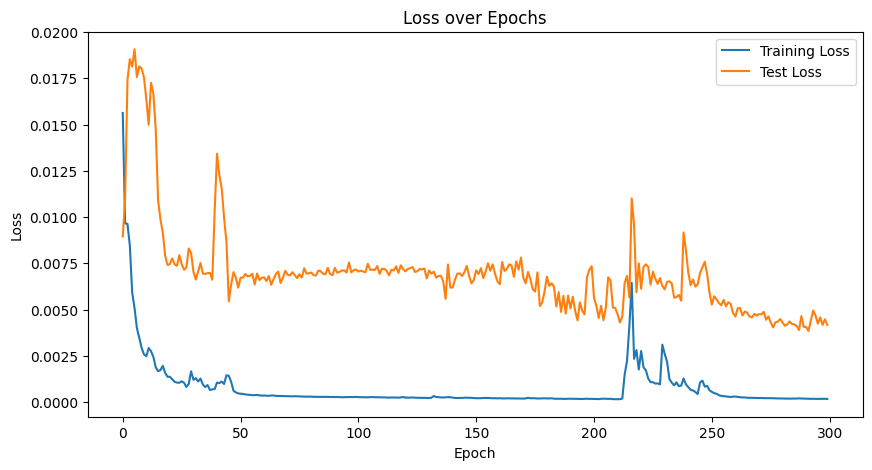

In [36]:
best_lstm_deep_model.plot_loss()

In [37]:
metrics(best_lstm_deep_model)

RMSE: 90.34950277641342
MAE: 84.51585905194523
MAPE: 11.135522617019479%


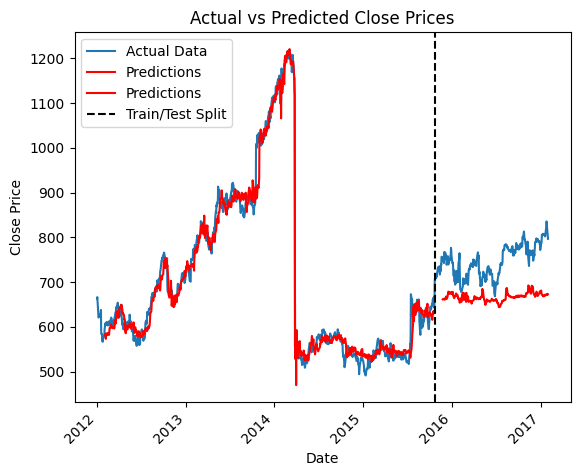

In [38]:
plot_data_and_prediction(model=best_lstm_deep_model, features_scaler=feature_scaler, target_scaler=target_scaler,
                         split_index=split_index,
                         input_sequence=INPUT_SEQUENCE, output_sequence=OUTPUT_SEQUENCE)

# GRU з декількома шарами

In [39]:
class GRUDeepModel(nn.Module, BasicRNN):
    def __init__(self, input_dim, hidden_dim, output_dim, input_sequence, output_sequence, num_layers=2):
        super(GRUDeepModel, self).__init__()
        # Set up a deep GRU with specified number of layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim * output_sequence)
        self.input_sequence = input_sequence
        self.output_sequence = output_sequence

    def forward(self, x):
        # Assume x is already shaped as (batch, input_sequence, features)
        out, _ = self.gru(x)  # Process input through the GRU layer
        # Reshape the output to fit into the fully connected layer
        out = out[:, -1, :]  # Taking the output of the last time step
        out = self.fc(out)
        # Reshape the output to have the output_sequence in the last dimension
        out = out.view(-1, self.output_sequence, out.size(-1) // self.output_sequence)
        return out
    
    @staticmethod
    def find_best_parameters(X_train, y_train, X_test, y_test, parameter_grid, criterion=nn.MSELoss()):
        best_loss = float('inf')
        best_params = None
        best_model = None

        for params in tqdm(list(it.product(*parameter_grid.values()))):
            lr, hidden_dim, batch_size, num_layers = params  # Include num_layers in the parameter grid
            input_dim = X_train.shape[-1]
            output_dim = y_train.shape[-1]

            model = GRUDeepModel(
                input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, 
                num_layers=num_layers, input_sequence=INPUT_SEQUENCE, output_sequence=OUTPUT_SEQUENCE
            ).to(DEVICE)
            current_best_model, current_best_test_loss = model.fit(X_train, y_train, X_test, y_test, num_epochs=300, 
                      batch_size=batch_size, learning_rate=lr, verbose=False)

#             test_dataset = TensorDataset(X_test, y_test)
#             test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
#             val_loss = model.evaluate(test_loader, criterion)

            if current_best_test_loss < best_loss:
                best_loss = current_best_test_loss
                best_params = params
                best_model = deepcopy(current_best_model)

        print(f'Best parameters found: {best_params}, with validation loss: {best_loss}')
        return best_params, best_model

In [40]:
parameter_grid = {
    'lr': [0.05, 0.01, 0.005],
    'hidden_dim': [10, 25, 35],
    'batch_size': [64],
    'layers': [2, 3, 4]
}

(best_gru_deep_params, best_gru_deep_model) = GRUDeepModel.find_best_parameters(
    X_train_tensor, y_train_tensor, 
    X_test_tensor, y_test_tensor, 
    parameter_grid)

  0%|          | 0/27 [00:00<?, ?it/s]

Best parameters found: (0.01, 25, 64, 4), with validation loss: 0.004898005764091055


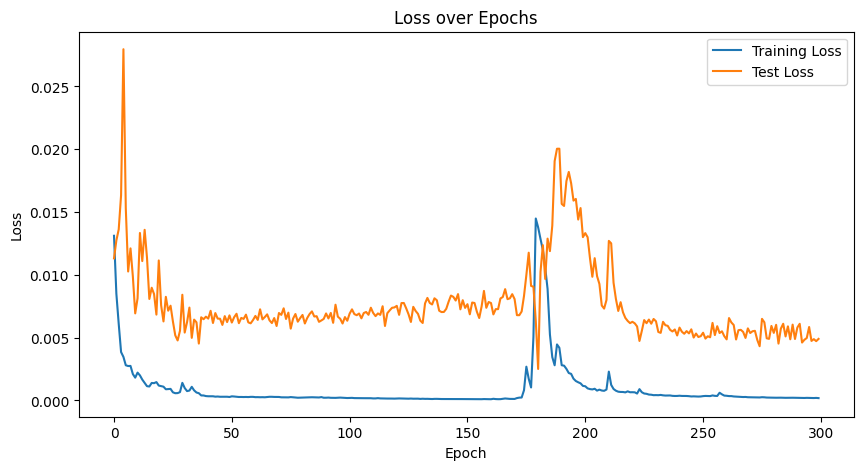

In [41]:
best_gru_deep_model.plot_loss()

In [42]:
metrics(best_gru_deep_model)

RMSE: 97.91424226886375
MAE: 91.18062576612478
MAPE: 12.012637835411068%


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:1102: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:1102: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:1102: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


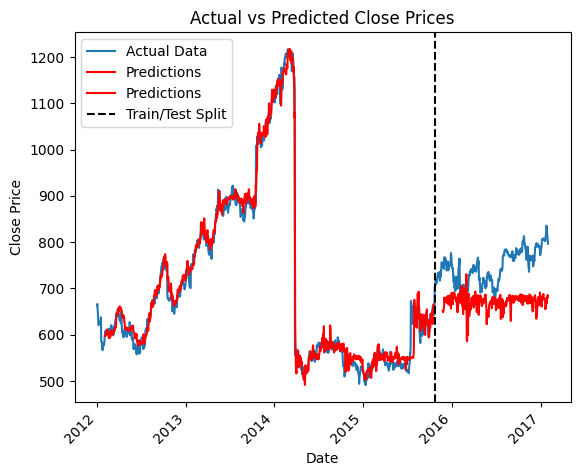

In [43]:
plot_data_and_prediction(model=best_gru_deep_model, features_scaler=feature_scaler, target_scaler=target_scaler,
                         split_index=split_index,
                         input_sequence=INPUT_SEQUENCE, output_sequence=OUTPUT_SEQUENCE)

## LSTM із дропаутами

In [44]:
class LSTMDropoutModel(nn.Module, BasicRNN):
    def __init__(self, input_dim, hidden_dim, output_dim, input_sequence, output_sequence, num_layers=2, dropout_rate=0.5):
        super(LSTMDropoutModel, self).__init__()
        # Include dropout_rate in the LSTM layer, dropout is applied between LSTM layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, output_dim * output_sequence)
        self.input_sequence = input_sequence
        self.output_sequence = output_sequence

    def forward(self, x):
        x = x.view(-1, self.input_sequence, x.size(-1))  # Ensure input is (batch, sequence, features)
        self.lstm.flatten_parameters()
        out, (h_n, c_n) = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        out = out.view(-1, self.output_sequence, out.size(-1) // self.output_sequence)
        return out
    
    @staticmethod
    def find_best_parameters(X_train, y_train, X_test, y_test, parameter_grid, criterion=nn.MSELoss()):
        best_loss = float('inf')
        best_params = None
        best_model = None

        for params in tqdm(list(it.product(*parameter_grid.values()))):
            lr, hidden_dim, batch_size, num_layers, dropout_rate = params  # Include num_layers in the parameter grid
            input_dim = X_train.shape[-1]
            output_dim = y_train.shape[-1]

            model = LSTMDropoutModel(
                input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, 
                num_layers=num_layers, input_sequence=INPUT_SEQUENCE, output_sequence=OUTPUT_SEQUENCE,
                dropout_rate=dropout_rate
            ).to(DEVICE)
            current_best_model, current_best_test_loss = model.fit(X_train, y_train, X_test, y_test, num_epochs=300, 
                      batch_size=batch_size, learning_rate=lr, verbose=False)


            if current_best_test_loss < best_loss:
                best_loss = current_best_test_loss
                best_params = params
                best_model = deepcopy(current_best_model)
                
        print(f'Best parameters found: {best_params}, with validation loss: {best_loss}')
        return best_params, best_model

In [58]:
# parameter_grid = {
#     'lr': [0.01],
#     'hidden_dim': [20],
#     'batch_size': [64],
#     'layers': [2],
#     'dropout_rate': [0]
# }

parameter_grid = {
    'lr': [0.05, 0.01],
    'hidden_dim': [15, 30],
    'batch_size': [64],
    'layers': [1, 2, 3, 4],
    'dropout_rate': [1e-4, 1e-3]
}

(best_lstm_drp_params, best_lstm_drp_model) = LSTMDropoutModel.find_best_parameters(
    X_train_tensor, y_train_tensor, 
    X_test_tensor, y_test_tensor, 
    parameter_grid)

  0%|          | 0/32 [00:00<?, ?it/s]

Best parameters found: (0.01, 30, 64, 1, 0.001), with validation loss: 0.002249783036684749


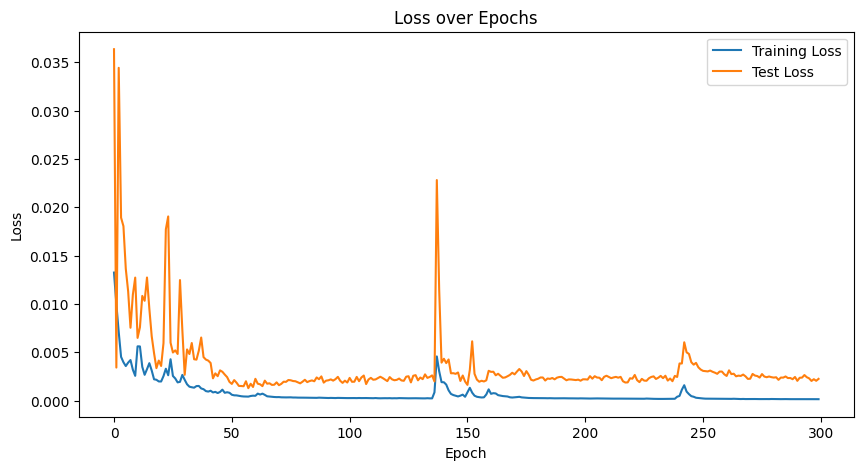

In [59]:
best_lstm_drp_model.plot_loss()

In [60]:
metrics(best_lstm_drp_model)

RMSE: 66.2919628733696
MAE: 60.20642900686553
MAPE: 7.925117022546193%


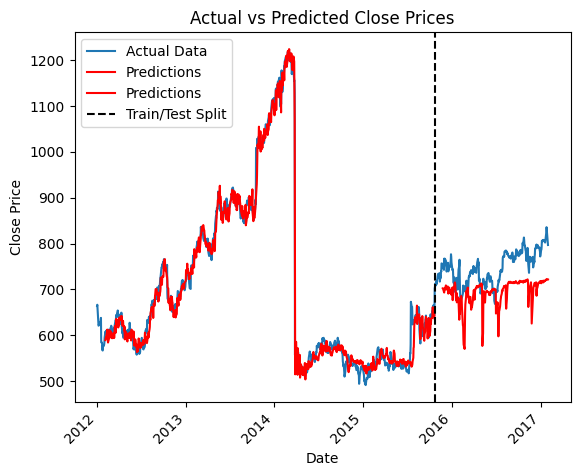

In [61]:
plot_data_and_prediction(model=best_lstm_drp_model, features_scaler=feature_scaler, target_scaler=target_scaler,
                         split_index=split_index,
                         input_sequence=INPUT_SEQUENCE, output_sequence=OUTPUT_SEQUENCE)

# GRU із дропаутами

In [49]:
class GRUDropoutModel(nn.Module, BasicRNN):
    def __init__(self, input_dim, hidden_dim, output_dim, input_sequence, output_sequence, num_layers=2, dropout_rate=0.5):
        super(GRUDropoutModel, self).__init__()
        # Set up a deep GRU with specified number of layers and dropout
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, output_dim * output_sequence)
        self.input_sequence = input_sequence
        self.output_sequence = output_sequence

    def forward(self, x):
        # Assume x is already shaped as (batch, input_sequence, features)
        out, _ = self.gru(x)  # Process input through the GRU layer
        # Reshape the output to fit into the fully connected layer
        out = out[:, -1, :]  # Taking the output of the last time step
        out = self.fc(out)
        # Reshape the output to have the output_sequence in the last dimension
        out = out.view(-1, self.output_sequence, out.size(-1) // self.output_sequence)
        return out
    
    @staticmethod
    def find_best_parameters(X_train, y_train, X_test, y_test, parameter_grid, criterion=nn.MSELoss()):
        best_loss = float('inf')
        best_params = None
        best_model = None

        for params in tqdm(list(it.product(*parameter_grid.values()))):
            lr, hidden_dim, batch_size, num_layers, dropout_rate = params  # Include num_layers in the parameter grid
            input_dim = X_train.shape[-1]
            output_dim = y_train.shape[-1]

            model = GRUDropoutModel(
                input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, 
                num_layers=num_layers, input_sequence=INPUT_SEQUENCE, output_sequence=OUTPUT_SEQUENCE,
                dropout_rate=dropout_rate
            ).to(DEVICE)
            current_best_model, current_best_test_loss = model.fit(X_train, y_train, X_test, y_test, num_epochs=300, 
                      batch_size=batch_size, learning_rate=lr, verbose=False)

            if current_best_test_loss < best_loss:
                best_loss = current_best_test_loss
                best_params = params
                best_model = deepcopy(current_best_model)

        print(f'Best parameters found: {best_params}, with validation loss: {best_loss}')
        return best_params, best_model

In [68]:
parameter_grid = {
    'lr': [0.05, 0.01],
    'hidden_dim': [15, 30],
    'batch_size': [64],
    'layers': [1, 2, 3, 4],
    'dropout_rate': [1e-4, 1e-3]
}

(best_gru_drp_params, best_gru_drp_model) = GRUDropoutModel.find_best_parameters(
    X_train_tensor, y_train_tensor, 
    X_test_tensor, y_test_tensor, 
    parameter_grid)

  0%|          | 0/32 [00:00<?, ?it/s]

Best parameters found: (0.01, 30, 64, 1, 0.0001), with validation loss: 0.003453258864004604


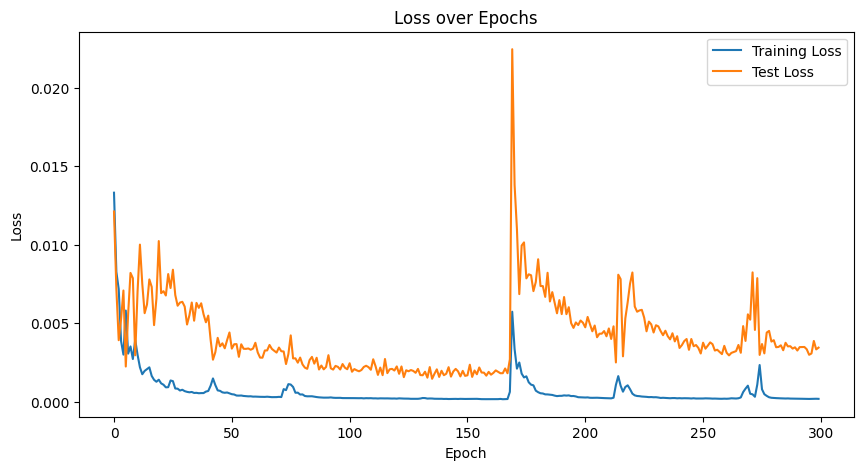

In [69]:
best_gru_drp_model.plot_loss()

In [70]:
metrics(best_gru_drp_model)

RMSE: 82.24991156368932
MAE: 75.15036176461884
MAPE: 9.889300848102149%


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:1102: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:1102: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:1102: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


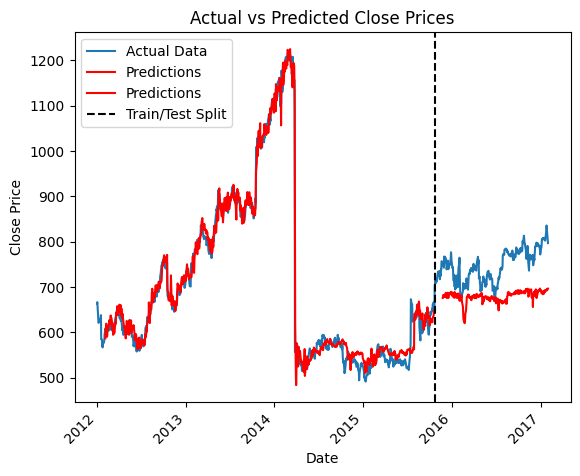

In [71]:
plot_data_and_prediction(model=best_gru_drp_model, features_scaler=feature_scaler, target_scaler=target_scaler,
                         split_index=split_index,
                         input_sequence=INPUT_SEQUENCE, output_sequence=OUTPUT_SEQUENCE)

## Аналіз часового ряду

In [76]:
data = df['Close'].values.reshape(-1, 1)

# Стандартизація даних
scaler = StandardScaler()
low_normalized = scaler.fit_transform(data)
# Розділення на тренувальний та тестовий набори
low_train = low_normalized[:split_index]
low_test = low_normalized[split_index:]

def create_conv_sequences(features, target, input_sequence, output_sequence):
    X = []
    y = []

    for i in range(len(features) - input_sequence - output_sequence + 1):
        X.append(features[i:(i + input_sequence)])
        y.append(target[(i + input_sequence):(i + input_sequence + output_sequence)])
    
    return np.array(X), np.array(y)


low_train_tensor = torch.tensor(low_train, dtype=torch.float32).unsqueeze(1) # Додаємо розмірність каналу
low_test_tensor = torch.tensor(low_test, dtype=torch.float32).unsqueeze(1)

In [90]:
class Conv1DModel(nn.Module, BasicRNN): # we use BasicRNN only for the fit method, which is the same
    def __init__(self, input_size=features.shape[1],
                 output_size=OUTPUT_SEQUENCE,
                 hidden_channels=16):
        super(Conv1DModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=hidden_channels, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(50) # Задаємо виходний розмір явно
        self.conv2 = nn.Conv1d(in_channels=hidden_channels, out_channels=hidden_channels*2, kernel_size=3, stride=1, padding=1)
        self.adaptive_pool = nn.AdaptiveMaxPool1d(25) # Додаткове зменшення розміру
        self.fc1 = nn.Linear(hidden_channels*2 * 25, 120)
        self.fc2 = nn.Linear(120, output_size)
        self.hidden_channels = hidden_channels
        
    def forward(self, x):
        x = F.relu(self.conv1(x.permute(0, 2, 1)))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.adaptive_pool(x)
        x = x.view(-1, self.hidden_channels*2 * 25) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.unsqueeze(-1)
    
    @staticmethod
    def find_best_parameters(X_train, y_train, X_test, y_test, parameter_grid, criterion=nn.MSELoss()):
        best_loss = float('inf')
        best_params = None
        best_model = None

        for params in tqdm(list(it.product(*parameter_grid.values()))):
            lr, hidden_dim, batch_size = params
            input_dim = X_train.shape[-1]
            output_dim = y_train.shape[-1]

            model = Conv1DModel(hidden_channels=hidden_dim).to(DEVICE)
            current_best_model, current_best_test_loss = model.fit(X_train, y_train, X_test, y_test, num_epochs=300, batch_size=batch_size, learning_rate=lr, verbose=False)

            if current_best_test_loss < best_loss:
                best_loss = current_best_test_loss
                best_params = params
                best_model = deepcopy(current_best_model)

        print(f'Best parameters found: {best_params}, with validation loss: {best_loss}')
        return best_params, best_model

In [93]:
parameter_grid = {
    'lr': [0.05, 0.01, 0.005, 0.001],
    'hidden_dim': [8, 12, 16, 24],
    'batch_size': [32, 64]
}
# parameter_grid = {
#     'lr': [0.01],
#     'hidden_dim': [16],
#     'batch_size': [64]
# }
(best_conv_oneD_params, best_conv_oneD_model) = Conv1DModel.find_best_parameters(
    X_train_tensor, y_train_tensor, 
    X_test_tensor, y_test_tensor, 
    parameter_grid)

  0%|          | 0/32 [00:00<?, ?it/s]

Best parameters found: (0.05, 16, 64), with validation loss: 0.00036823031765342965


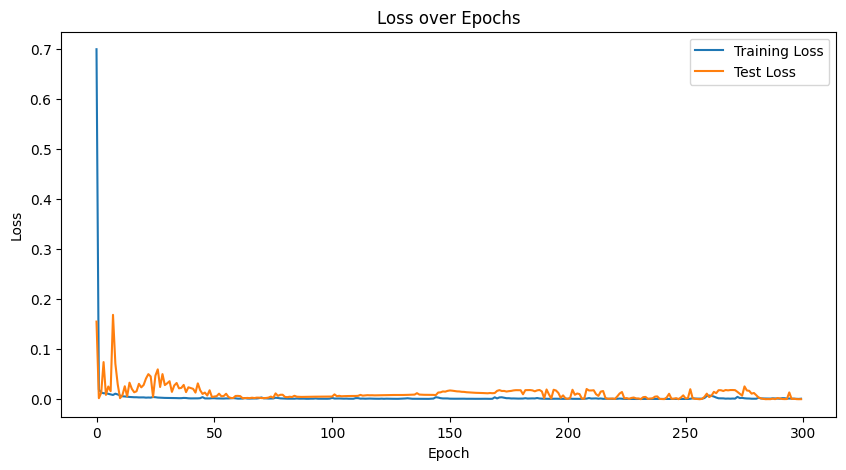

In [94]:
best_conv_oneD_model.plot_loss()

In [95]:
metrics(best_conv_oneD_model)

RMSE: 27.482024581845195
MAE: 21.525218948107376
MAPE: 2.8822463476831253%


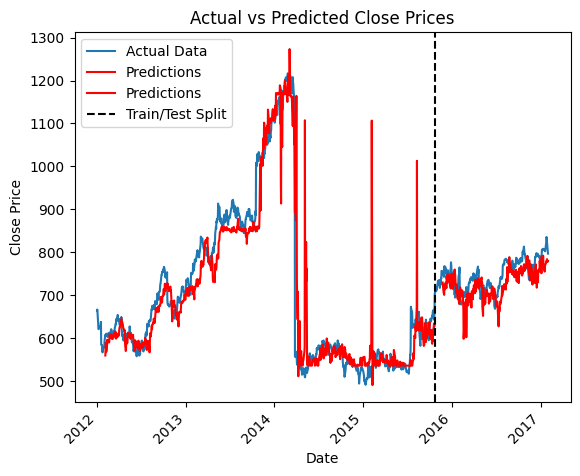

In [96]:
plot_data_and_prediction(model=best_conv_oneD_model, features_scaler=feature_scaler, target_scaler=target_scaler,
                         split_index=split_index,
                         input_sequence=INPUT_SEQUENCE, output_sequence=OUTPUT_SEQUENCE)

In [98]:
y_test_tensor.shape

torch.Size([297, 10, 1])

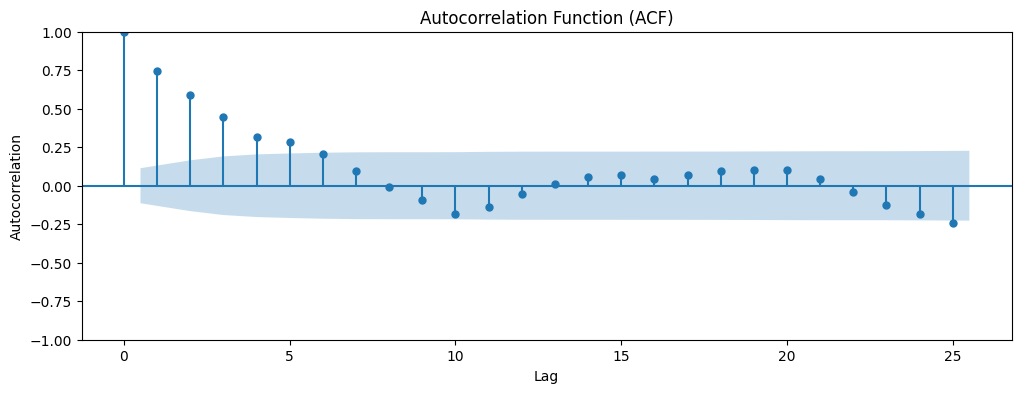

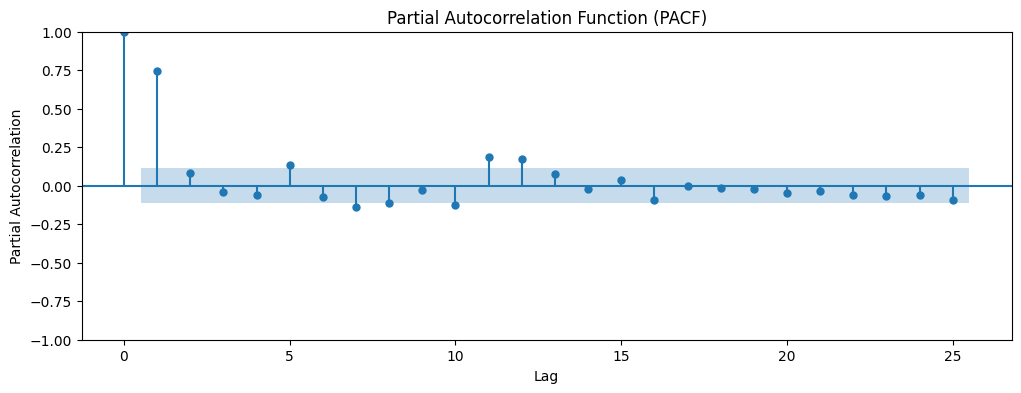

The resid variable is autocorrelated.


In [108]:
import statsmodels.api as sm

with torch.no_grad(): # Виключаємо градієнти для прогнозування
    predictions = best_conv_oneD_model(X_test_tensor.to(DEVICE))[:,OUTPUT_SEQUENCE-1,:]
    # Порівняння прогнозів з реальними значеннями для визначення решток
    residuals = y_test_tensor[:,OUTPUT_SEQUENCE-1,:].to('cpu') - predictions.to('cpu')

# Аналіз решток на автокореляцію
residuals_np = residuals.detach().numpy().flatten()

# Plot ACF
fig, ax = plt.subplots(figsize=(12, 4))
plot_acf(residuals_np, ax=ax)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')

# Plot PACF
fig, ax = plt.subplots(figsize=(12, 4))
plot_pacf(residuals_np, ax=ax)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')

plt.show()

# Perform Ljung-Box test
lb_test_results = acorr_ljungbox(residuals_np, lags=25)

# Extract p-values from the test results
p_values = lb_test_results['lb_pvalue']

# Check if any p-value is less than the significance level (e.g., 0.05)
is_autocorrelated = any(p < 0.05 for p in p_values)

if is_autocorrelated:
    print("The resid variable is autocorrelated.")
else:
    print("The resid variable is not autocorrelated.")

Значення автокореляції (позначені синіми кружечками) на перших кількох затримках виходять за межі довірчих інтервалів, але до затримки 5 вони починають наближатися до нуля. Це дає підстави припустити наявність слабкої автокореляції в залишках на малих затримках. Отримане значення PACF у 0.75 на затримці 1 також підтверджує це, вказуючи на наявність помірно вираженої кореляції між поточним залишком та залишком на попередньому часовому кроці. Застосування тесту Льюнга-Бокса підтвердило наш початковий аналіз: залишки дійсно мають автокореляцію.

# Порівняння моделей 

| Модель | RMSE | MAE | MAPE |
| --- | --- | --- | --- | 
| Базова рекурентна | 34.27 | 28.25 | 3.78 |
| Базова LSTM | 54.33 | 47.90 | 6.27 |
| Базова GRU | 48.49 | 39.62 | 5.21 |
| Багатошарова LSTM | 90.34 | 84.51 | 11.13 |
| Багатошарова GRU | 97.91 | 91.18 | 12.01 |
| Дропаут LSTM | 66.29 | 60.20 | 7.92 |
| Дропаут GRU | 82.24 | 75.15 | 9.88 |



Базова рекурентна модель показує найкращі результати за всіма трьома показниками (RMSE = 34.27, MAE = 28.25, MAPE = 3.78), що робить її найбільш точною серед представлених моделей для даної задачі.

Базова LSTM та базова GRU моделі мають вищі значення помилок, порівняно з базовою рекурентною моделлю, що може свідчити про те, що додавання механізмів управління пам'яттю (які є в LSTM і GRU) не обов'язково призводить до покращення результатів для цієї конкретної задачі.

Багатошарові LSTM та GRU моделі показують значно гірші результати, ніж їхні одношарові аналоги. Це може бути пов'язано з перенавчанням або з тим, що додаткові шари ускладнюють модель, не приносячи користі в точності передбачення для даного набору даних.

Дропаут LSTM та GRU моделі мають кращі показники, ніж багатошарові моделі, але все ж значно гірші, ніж базові варіанти. Додавання дропауту, який має допомогти в боротьбі з перенавчанням, в даному випадку, здається, призводить до зниження точності передбачень.